# CNN Dog Breed Classication

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. This dataset is being imported from Kaggle

The contents of the dataset are:

 - **Number of categories**: 120
 - **Number of images**: 20,580
Since there are only about 170 images per category. It would be beneficial to use transfer learning.

I will be using the pre-trained model Inception V3 which has been trained on 'imagenet'. The weights will be freezed.

## Libraries and Config

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math
import numpy as np
import os


In [35]:
tf.__version__

'2.16.1'

In [36]:
IMAGE_SIZE = 256
BATCH_SIZE = 256
CHANNELS = 3

In [37]:

inception = tf.keras.applications.InceptionV3(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False, 
    weights='imagenet')

inception.trainable = False

In [38]:
def class_names_txt(filepath):
    """
    Read a text file and save each line as an element in a list.

    Args:
    - filepath (str): The path to the text file.

    Returns:
    - lines (list): A list containing each line of the text file as an element.
    """
    names = []
    with open(filepath, 'r') as file:
        for line in file:
            # Remove newline characters and any trailing/leading whitespaces
            cleaned_line = line.strip()
            cleaned_line = cleaned_line.replace("'", "")
            cleaned_line = cleaned_line.replace(",", "")
            names.append(cleaned_line)
    return names

filepath = "Dataset/breeds.txt"  
class_names = class_names_txt(filepath)

## Data Augmentation

In [39]:
train_data_dir = './Dataset/Images/'

train_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                                   rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range = 15,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, #mini-batches of size 512 images are used
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, #mini-batches of size 512 images
    class_mode='categorical',
    subset='validation')

TRAIN_SIZE = train_generator.samples
VALIDATION_SIZE = validation_generator.samples

print("Train size: ", TRAIN_SIZE)
print("Validation size: ", VALIDATION_SIZE)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Train size:  16508
Validation size:  4072


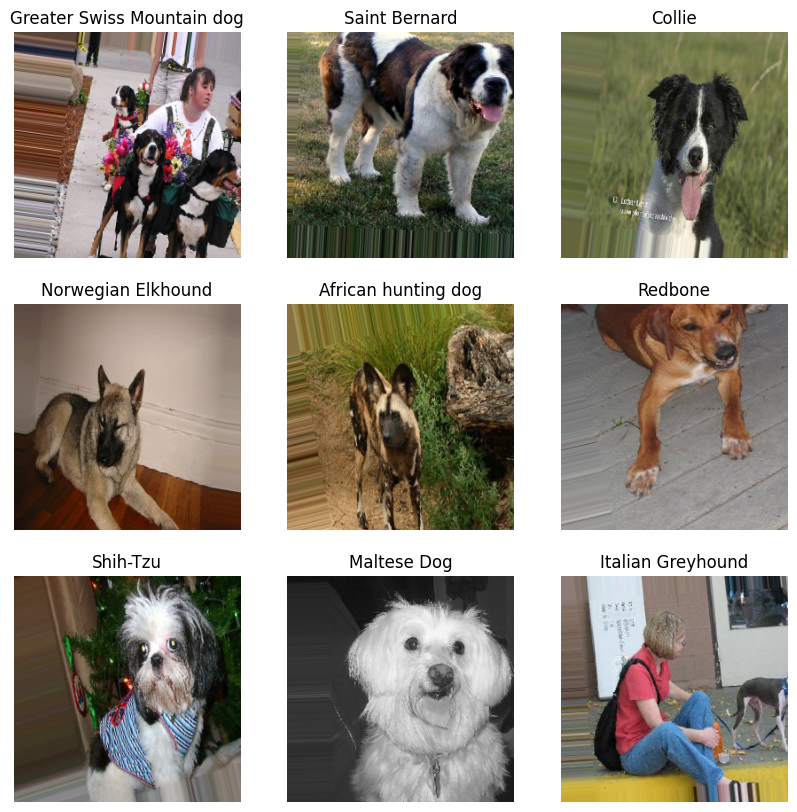

In [40]:
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## Model

In [41]:

model = tf.keras.Sequential([
                             inception, #inception layer
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(rate=0.2), #Dropout layer
                             tf.keras.layers.Dense(240,activation='relu'),
                             tf.keras.layers.Dropout(rate=0.1), #Dropout layer
                             tf.keras.layers.Dense(240,activation = 'relu'),
                             tf.keras.layers.Dropout(rate=0), #Dropout layer
                             tf.keras.layers.Dense(120,activation = 'softmax')
                             
])

In [42]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.99)
model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [44]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE),
    validation_data = validation_generator, 
    validation_steps = int(VALIDATION_SIZE/BATCH_SIZE),
    epochs = EPOCHS)

Epoch 1/20


2024-05-15 14:54:38.073989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 14:54:48.709934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 655s 10s/step - accuracy: 0.7905 - loss: 0.6927 - val_accuracy: 0.7792 - val_loss: 0.7976
Epoch 2/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:47 7s/step - accuracy: 0.7930 - loss: 0.7346

2024-05-15 15:05:29.529359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.7930 - loss: 0.7346 - val_accuracy: 0.8578 - val_loss: 0.6706
Epoch 3/20


2024-05-15 15:05:36.340943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 15:05:47.292114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 15:05:57.920463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 654s 10s/step - accuracy: 0.7981 - loss: 0.6799 - val_accuracy: 0.7742 - val_loss: 0.8179
Epoch 4/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:54 8s/step - accuracy: 0.8047 - loss: 0.6656

2024-05-15 15:16:38.138057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.8047 - loss: 0.6656 - val_accuracy: 0.7414 - val_loss: 0.9892
Epoch 5/20


2024-05-15 15:16:44.605202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 15:16:55.593525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 15:17:06.232845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 653s 10s/step - accuracy: 0.7984 - loss: 0.6557 - val_accuracy: 0.7685 - val_loss: 0.8420
Epoch 6/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 8:03 8s/step - accuracy: 0.7695 - loss: 0.7899

2024-05-15 15:27:45.688726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.7695 - loss: 0.7899 - val_accuracy: 0.6940 - val_loss: 1.1033
Epoch 7/20


2024-05-15 15:27:52.336484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 15:28:03.482654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 15:28:14.267794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 683s 10s/step - accuracy: 0.8034 - loss: 0.6610 - val_accuracy: 0.7695 - val_loss: 0.8508
Epoch 8/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 8:29 8s/step - accuracy: 0.8086 - loss: 0.6357

2024-05-15 15:39:23.172651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.8086 - loss: 0.6357 - val_accuracy: 0.7931 - val_loss: 0.7033
Epoch 9/20


2024-05-15 15:39:30.201259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 15:39:41.865345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 15:39:52.728620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 672s 10s/step - accuracy: 0.8052 - loss: 0.6467 - val_accuracy: 0.7711 - val_loss: 0.8435
Epoch 10/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 8:16 8s/step - accuracy: 0.7969 - loss: 0.6008

2024-05-15 15:50:50.049066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.7969 - loss: 0.6008 - val_accuracy: 0.7284 - val_loss: 0.9590
Epoch 11/20


2024-05-15 15:50:56.968912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 15:51:08.346256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 15:51:19.247984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 662s 10s/step - accuracy: 0.8089 - loss: 0.6389 - val_accuracy: 0.7766 - val_loss: 0.8420
Epoch 12/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 8:21 8s/step - accuracy: 0.7734 - loss: 0.7380

2024-05-15 16:02:07.143868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7734 - loss: 0.7380 - val_accuracy: 0.8319 - val_loss: 0.6856
Epoch 13/20


2024-05-15 16:02:14.054600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 16:02:25.135910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 16:02:35.803874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 666s 10s/step - accuracy: 0.8155 - loss: 0.6240 - val_accuracy: 0.7724 - val_loss: 0.8348
Epoch 14/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:57 8s/step - accuracy: 0.7969 - loss: 0.8006

2024-05-15 16:13:27.420393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7969 - loss: 0.8006 - val_accuracy: 0.7586 - val_loss: 0.8583
Epoch 15/20


2024-05-15 16:13:34.270935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 16:13:45.330408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 16:13:56.191462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 670s 10s/step - accuracy: 0.8088 - loss: 0.6035 - val_accuracy: 0.7745 - val_loss: 0.8151
Epoch 16/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:54 8s/step - accuracy: 0.7695 - loss: 0.7841

2024-05-15 16:24:51.670329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.7695 - loss: 0.7841 - val_accuracy: 0.7974 - val_loss: 0.8352
Epoch 17/20


2024-05-15 16:24:58.540159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 16:25:10.053649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 16:25:19.417653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 644s 10s/step - accuracy: 0.8154 - loss: 0.5899 - val_accuracy: 0.7771 - val_loss: 0.8174
Epoch 18/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:26 7s/step - accuracy: 0.8281 - loss: 0.6355

2024-05-15 16:35:49.924684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.8281 - loss: 0.6355 - val_accuracy: 0.7414 - val_loss: 0.8528
Epoch 19/20


2024-05-15 16:35:56.675988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-15 16:36:07.323247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:49: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-15 16:36:17.477042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 651s 10s/step - accuracy: 0.8163 - loss: 0.5915 - val_accuracy: 0.7872 - val_loss: 0.8141
Epoch 20/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 7:30 7s/step - accuracy: 0.8008 - loss: 0.6817

2024-05-15 16:46:54.817575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.8008 - loss: 0.6817 - val_accuracy: 0.7845 - val_loss: 0.8270


2024-05-15 16:47:01.467138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [45]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

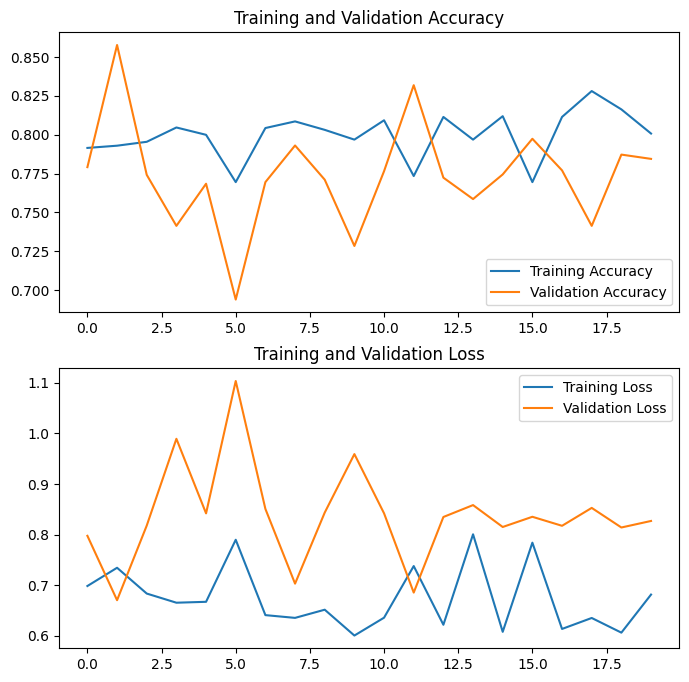

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 741ms/step


TypeError: Invalid shape () for image data

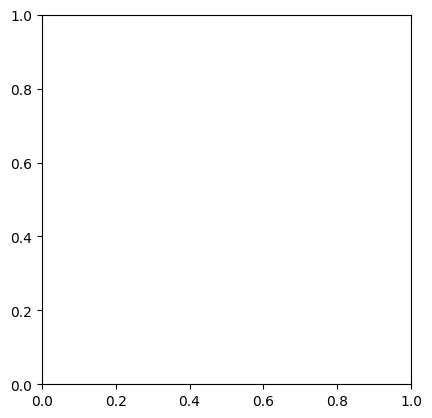

In [56]:

batch_prediction = model.predict(images)
random_int = np.random.randint(0, len(batch_prediction[0]))
batch_prediction.shape
images_predict, labels_predict = batch_prediction[0], batch_prediction[1]

plt.imshow(images_predict[random_int])
plt.show()

print(f"Actual Label: {class_names[np.argmax(labels[random_int])]}")
print(f"Predicted Label: {class_names[np.argmax(labels_predict[random_int])]}")

In [49]:
model_version = "SGD-0.01-0.99-20epochs"
model.save(f"./models/{model_version}.keras")